<a href="https://colab.research.google.com/github/Maksmephist/FoodFind-app/blob/main/%22food_classificator_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ипортируем необходимые фреймворки и библиотеки, скачиваем датасет

In [ ]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import cv2
import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [ ]:
# Клонируем репозиторий с примерами для тестирования обученной модели
!git clone https://github.com/tensorflow/examples.git

Cloning into 'examples'...
remote: Enumerating objects: 20132, done.
remote: Counting objects: 100% (1952/1952), done.
remote: Compressing objects: 100% (1049/1049), done.
remote: Total 20132 (delta 900), reused 1582 (delta 592), pack-reused 18180
Receiving objects: 100% (20132/20132), 33.15 MiB | 20.81 MiB/s, done.
Resolving deltas: 100% (10994/10994), done.


In [ ]:
# Скачиваем архив с датасетом food-101, распаковываем его
tf.keras.utils.get_file(
'food-101.tar.gz',
'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
cache_subdir='/content',
extract=True,
archive_format='tar',
cache_dir=None)

4996292608/4996278331 [==============================] - 85s 0us/step


'/content/food-101.tar.gz'

# Изучаем датасет


* Мы использовали датасет [Food 101](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/)
* В нём представленны 101 тысяча фотографий различной еды, разделённых на 101 класс
* Каждый из классов имеет  750 тренировочных изображений и 250 тестовых
* Все изображения масштабированы таким образом, чтобы длина сторон не превышала 512 пикселей

In [ ]:
# Check the extracted dataset folder
os.listdir('food-101/')

['README.txt', 'images', 'license_agreement.txt', 'meta']

**images** folder contains 101 folders with 1000 images  each  
Each folder contains images of a specific food class

In [ ]:
os.listdir('food-101/images')

**meta** содержит текстовые файлы - train.txt и test.txt\
**train.txt** содержит список изображений, принадлежащих обучающему набору  
**test.txt** содержит список изображений, принадлежащих тестовому набору\
**classes.txt** одержит список всех классов продуктов питания

In [ ]:
os.listdir('food-101/meta')

# Посмотрим на случайные изображения из некоторых классов

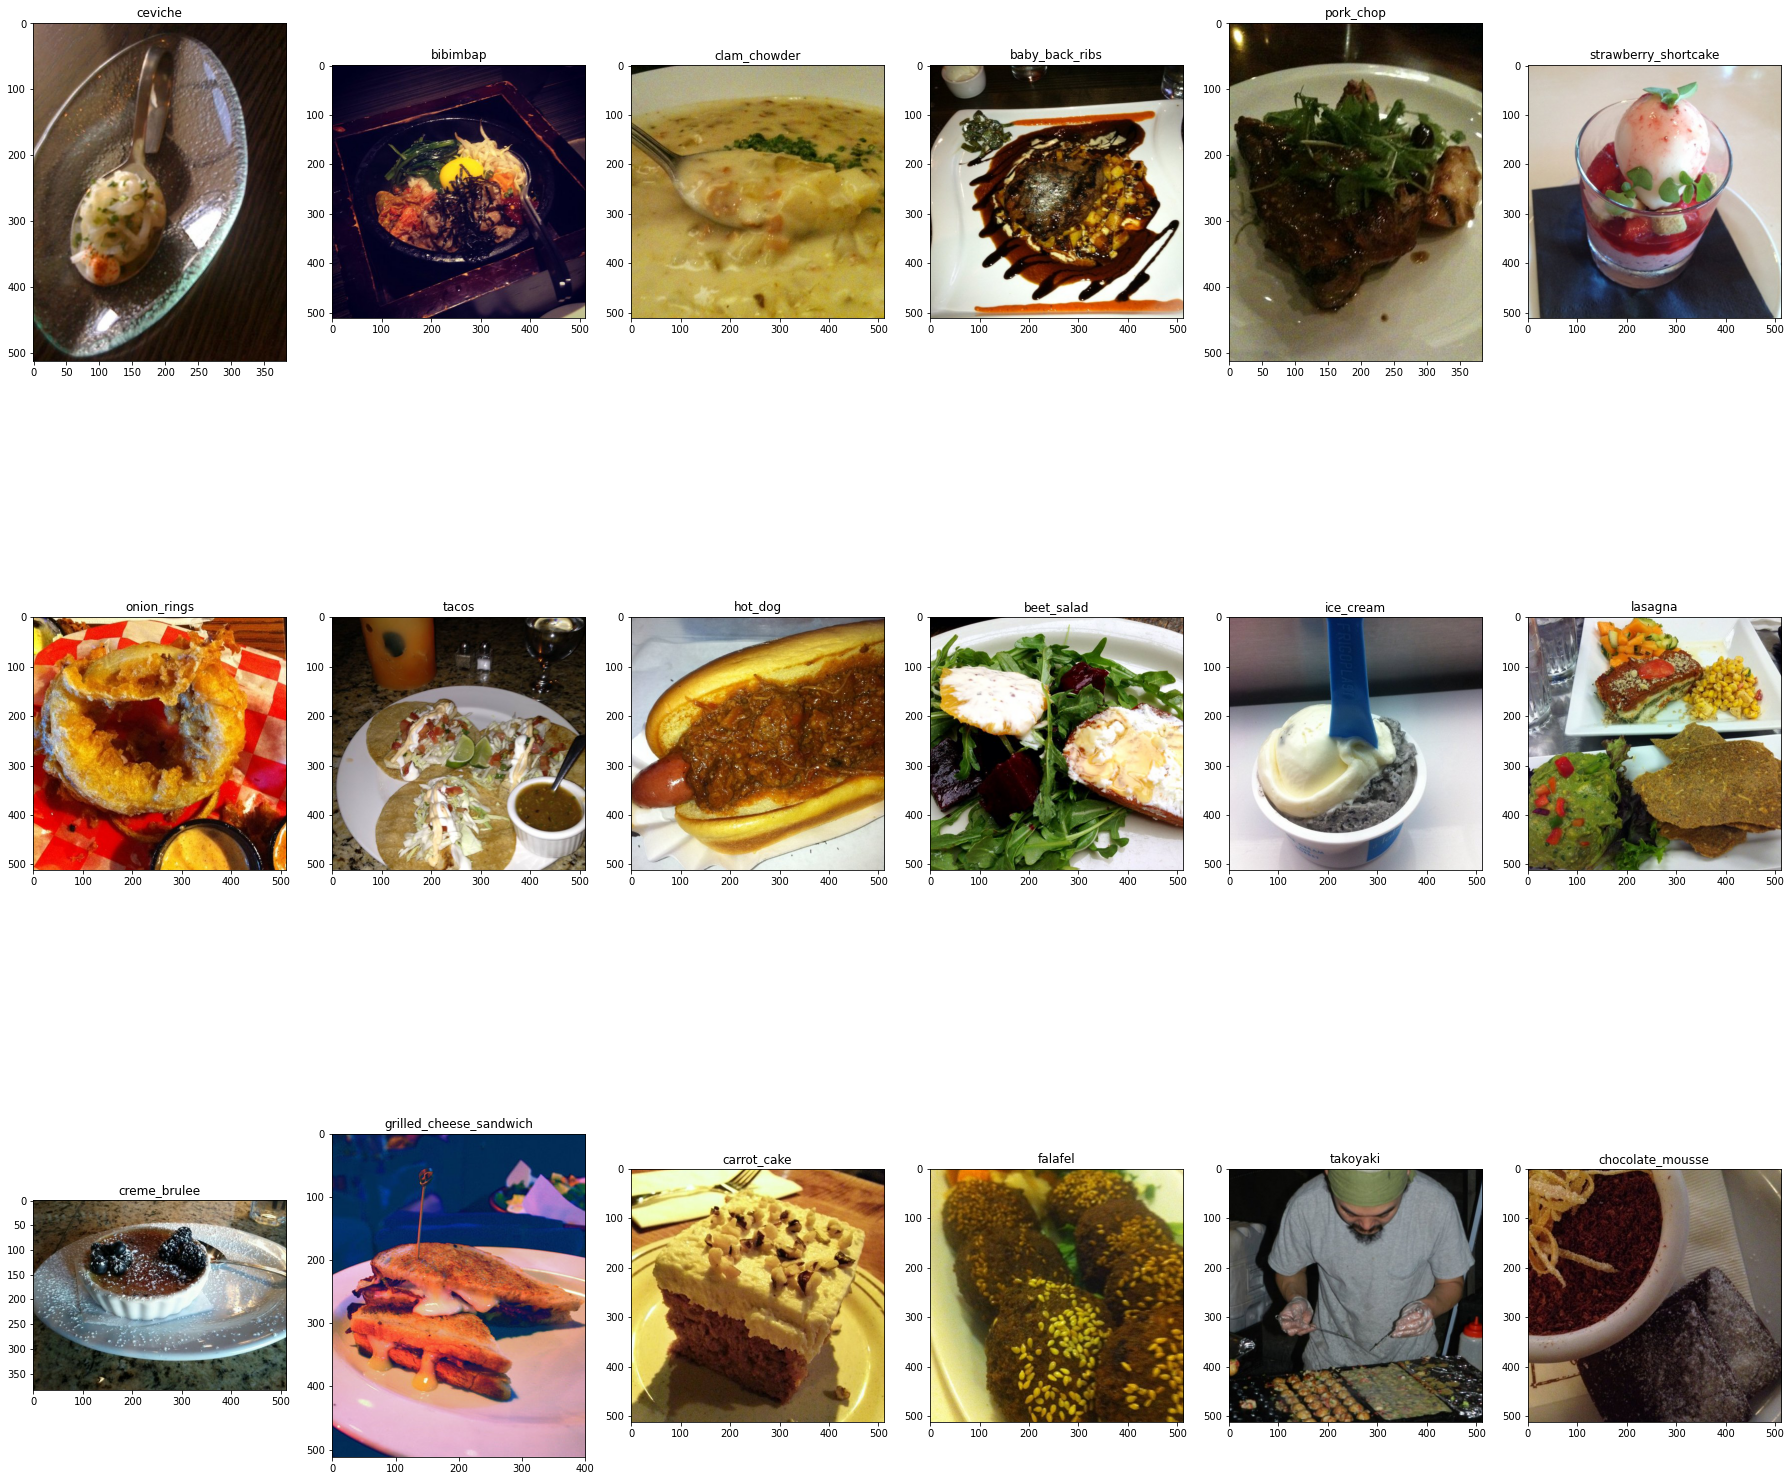

In [ ]:
# Visualize the data, showing one image per class from 101 classes
rows = 3
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("")
data_dir = "food-101/images/"
food_id = 0
for i in range(rows):
  for j in range(cols):
    food_selected = os.listdir(data_dir)[food_id] 
    food_id += 1
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected))
    food_selected_random = np.random.choice(food_selected_images) 
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected)
plt.tight_layout()



# Разделим изображения на тренировочные и тестовые

In [ ]:
# Всопомогательная функция для разделения исходного набора данных
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')
  for food in classes_images.keys():
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))


In [ ]:
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

In [ ]:
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

# Отделим от датасета несколько классов для тестового обучения

* У нас есть готовые данные для обучения и тестирования
* Но для тестов использовать все классы не представляется возможным, обучение будет занимать очень много времени 
* Чтобы продолжить дальнейшие эксперименты создадим train_min и test_mini, состоящие из 3 классов
* Since the original problem is multiclass classification which makes key aspects of architectural decisions different from that of binary classification, choosing 3 classes is a good start instead of 2

In [ ]:
#функция для создания нашего мини-датасета
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest)
  os.makedirs(dest)
  for food_item in food_list :
    print("Копируем изображения в",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))

In [ ]:
# выберем 3 класса для дальнейшей работы
food_list = ['sushi','pizza','hamburger']
src_train = 'food-101/train'
dest_train = 'food-101/train_mini'
src_test = 'food-101/test'
dest_test = 'food-101/test_mini'

In [ ]:
dataset_mini(food_list, src_train, dest_train)

Копируем изображения в sushi
Копируем изображения в pizza
Копируем изображения в hamburger


In [ ]:
dataset_mini(food_list, src_test, dest_test)

Копируем изображения в sushi
Копируем изображения в pizza
Копируем изображения в hamburger


# Точная настройка начальной предварительно подготовленной модели с использованием набора данных food-101


* Keras- библиотека глуобого обучения предоставляют возможность работы с предварительно обученными моделями
* Это глубокие нейронные сети с эффективной архитектурой, которые уже обучены наборам данных, таким как ImageNet (По состоянию на 2016 год в базу данных было записано около **десяти миллионов** URL с изображениями, которые прошли ручную аннотацию)
* Используя эти модели, мы можем использовать уже посчитанные веса и добавить несколько слоев нейронов сверху, чтобы точно настроить модель под наши данные  
* Это экономит время и вычисления по сравнению с моделями, обучаемыми с нуля

* Используем приведенный ниже код для точной настройки предварительно подготовленной модели Inception v3

In [ ]:
def train_model(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
  K.clear_session()

  img_width, img_height = 299, 299
  train_data_dir = 'food-101/train_mini'
  validation_data_dir = 'food-101/test_mini'
  batch_size = 16
  bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
  trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
  history_path = 'history_'+str(n_classes)+'.log'

  train_datagen = ImageDataGenerator(
      preprocessing_function=preprocess_input,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

  train_generator = train_datagen.flow_from_directory(
      train_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')

  validation_generator = test_datagen.flow_from_directory(
      validation_data_dir,
      target_size=(img_height, img_width),
      batch_size=batch_size,
      class_mode='categorical')


  inception = InceptionV3(weights='imagenet', include_top=False)
  x = inception.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(128,activation='relu')(x)
  x = Dropout(0.2)(x)

  predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

  model = Model(inputs=inception.input, outputs=predictions)
  model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
  csv_logger = CSVLogger(history_path)

  history = model.fit_generator(train_generator,
                      steps_per_epoch = nb_train_samples // batch_size,
                      validation_data=validation_generator,
                      validation_steps=nb_validation_samples // batch_size,
                      epochs=num_epochs,
                      verbose=1,
                      callbacks=[csv_logger, checkpoint])

  model.save(trainedmodel_path)
  class_map = train_generator.class_indices
  return history, class_map

In [ ]:
# Обучение модели для распознования  3х классов
n_classes = 3
epochs = 5
nb_train_samples = sum([len(files) for i, j, files in os.walk("food-101/train_mini")])
nb_validation_samples = sum([len(files) for i, j, files in os.walk("food-101/test_mini")])

history, class_map_3 = train_model(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_3)

Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/5
140/140 [==============================] - ETA: 0s - loss: 1.0035 - accuracy: 0.5515
Epoch 00001: val_loss improved from inf to 0.63885, saving model to bestmodel_3class.hdf5
140/140 [==============================] - 100s 661ms/step - loss: 1.0035 - accuracy: 0.5515 - val_loss: 0.6389 - val_accuracy: 0.8682
Epoch 2/5
140/140 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.8048
Epoch 00002: val_loss improved from 0.63885 to 0.41779, saving model to bestmodel_3class.hdf5
140/140 [==============================] - 91s 650ms/step - loss: 0.6499 - accuracy: 0.8048 - val_loss: 0.4178 - val_accuracy: 0.9198
Epoch 3/5
140/140 [==============================] - ETA: 0s - loss: 0.4670 - accuracy: 0.8648
Epoch 00003: val_loss improved from 0.41779 to 0.29611, saving model to bestmodel_3class.hdf5
140/140 [==============================] - 91s 646ms/step - loss: 0.4670 - accuracy: 0.8648 - val_loss: 0.2961 - val_accuracy: 0.9402
Epoch 4/5
140/140 [===============

# Посмотрим на графики точности и потерь

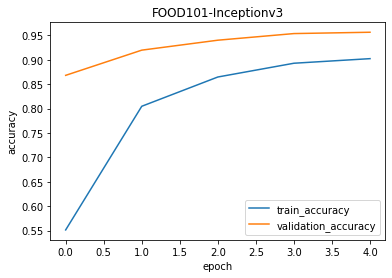

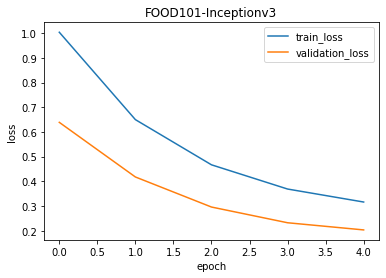

In [ ]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

* Графики показывают, что точность модели возрастала с эпохами, а потери уменьшались, собственно это и должно происходить при обучении
* Точность при проверке была выше, чем точность обучения, но это объяснимо:
  * Мы использовали предварительно обученную модель, которая уже содержит    данные из огромного множетсва классов
  * Использование технологии "отсева" в глубоких нейросетях(dropuot) приводит к высокой точности проверки
* После нескольких эпох точность ответа возросла до 95 %
 


# Дадим обученной модели спрогнозировать классы для случайных изображений из интернета

In [ ]:
%%time
#Загрузим сохранённую ранее модель, обученнную на 3х классах

K.clear_session()
model_best = load_model('bestmodel_3class.hdf5',compile = False)

CPU times: user 2.53 s, sys: 132 ms, total: 2.66 s
Wall time: 2.62 s


In [ ]:
def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img = preprocess_input(img)                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    food_list.sort()
    pred_value = food_list[index]
    #print(pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()
  

In [ ]:
# Make a list of images and test the trained model
images = []
imagepath = '/content/examples/my_examples/'
images.append(imagepath+'sushi.jpg')
images.append(imagepath+'pizza.jpg')
images.append(imagepath+'hamburger.jpg')
predict_class(model_best, images, True)

FileNotFoundError: ignored

# Выводы

* Мы обучили модель на 3 классах и протестировали ее с использованием новых данных, она успешно опеределила класс всех предложенных изображений
* Результаты обучения на 101 классе оказались примерно теми же, однако каждая эпоха обучения занимала околоо часа. Из-за налогаемых платфомрой ограничений за раз удалось провести 8 эпох обучения, этого оказалось достаточно для получения точности около 73 процентов
* Однако обучение шло без каких либо проблем и точность, как и в случае с малым количесвом классов, постепенно повышалась. Таким образом если использовать возможность дообучения модели, представленные в keras, можно добиться более высокой точности в прогнозировании классов.
* Само обучение оставим за кадром, ведь все отличия заключаются в том, чтобы не содавать train_mini и test_mini, а пустить обучение на исходном датасете, а так же отредактировать количество эпох обучения.
* В качестве предварительно подготовленной модели была использована Inceptionv3. Она обеспечила хорошую скорость обучения без потери его качества. 


# Литература
* [Building Powerful Image Classification Models](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
* [How Convolutional Neural Networks See the World](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
* [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)
* [Feature Visualization](https://distill.pub/2017/feature-visualization/)